# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira||

## Introduction 
Put some introduction here

## Package Instalation and Importing

In [1]:
#import sys
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [3]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [4]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [5]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [6]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [7]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [8]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [9]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [10]:
def MinMaxScaler_df(df,features):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_standard = df.copy()
    scaled_feat = scaler.fit_transform(df_standard[features])
    df_standard[features] = scaled_feat
    return df_standard

In [11]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [12]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [13]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [14]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [15]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)

    # Scale Data
    if 'Income' in new_df.columns:
        featuresToScale = new_df.columns.drop('Income')
    else:
        featuresToScale = new_df.columns
    new_df = MinMaxScaler_df(new_df,featuresToScale)

    return new_df.copy()

In [16]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [17]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.157895,-0.204082,-1.000000,-0.151549,1,-0.232877,0.200000,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
12487,0.052632,-0.204082,-1.000000,-1.000000,1,-0.315068,0.066667,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
12488,0.052632,-0.081633,-1.000000,-0.133632,1,-0.397260,0.066667,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
12489,-0.052632,-0.265306,-0.912276,-1.000000,1,0.260274,-0.200000,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0
12490,1.000000,-0.102041,-1.000000,-1.000000,1,-0.561644,1.000000,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0


## Model Creation
In this section, we will create the models.

In [18]:
def plot_cf(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [19]:
def run_metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    cf_matrix = confusion_matrix(y_train, pred_train)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_train, pred_train, average='macro')))
    print("ROC_AUC: {}".format(roc_auc_score(y_train, pred_train)))



    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    cf_matrix = confusion_matrix(y_val, pred_val)
    print(cf_matrix)
    print("F1: {}".format(f1_score(y_val, pred_val, average='macro')))
    print("ROC_AUC: {}".format(roc_auc_score(y_val, pred_val)))
    
    fpr, tpr, thresholds = roc_curve(y_val, pred_val)

In [50]:
def run_model(model,X_train, X_test, y_train, y_test):

    features = selectFeatures(model,X_train,y_train)
    X_train =  X_train[X_train.columns[features]]
    X_test =  X_test[X_test.columns[features]]

    model.fit(X_train,y_train)
    scores = cross_validate(model, X_train,y_train, cv=10,scoring=('f1_macro'))

    labels_train = model.predict(X_train)
    labels_val = model.predict(X_test)
    run_metrics(y_train, labels_train, y_test, labels_val)
    plot_cf(y_test,labels_val)

In [21]:
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators']
                                 , max_depth = int(space['max_depth'])
                                 , learning_rate = space['learning_rate']
                                 , gamma = space['gamma']
                                 , min_child_weight = space['min_child_weight']
                                 , subsample = space['subsample']
                                 , colsample_bytree = space['colsample_bytree'])
  
    classifier.fit(optimizer_X_train, optimizer_y_train)
    accuracies = cross_val_score(estimator = classifier, X = optimizer_X_train, y = optimizer_y_train, cv = 5, scoring = 'roc_auc')
    CrossValMean = accuracies.mean()
  
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

In [47]:
def selectFeatures(model,X,y):
    
    model.fit(X,y)
    featureModel = SelectFromModel(model, prefit=True, threshold='mean')
    return featureModel.get_support()

### Correlation

In [26]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df

,Ticket Price,Working Hours per week,Money Received,Years of Education,Ticket Price,Income,Age,Education_Class,Group_A,Group_B,Group_C
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Working Hours per week,0.052959,1.000000,0.075471,0.138516,0.052959,0.219890,0.064900,0.144922,-0.092201,0.074887,0.048958
Money Received,-0.031330,0.075471,1.000000,0.123015,-0.031330,0.221440,0.072693,0.118556,-0.373136,0.481099,-0.031953
Years of Education,0.084810,0.138516,0.123015,1.000000,0.084810,0.333089,0.035241,0.984065,-0.142698,0.111686,0.081220
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Income,0.155890,0.219890,0.221440,0.333089,0.155890,1.000000,0.233157,0.330227,-0.305667,0.263008,0.143257
Age,0.055774,0.064900,0.072693,0.035241,0.055774,0.233157,1.000000,0.031290,-0.125038,0.115570,0.048285
Education_Class,0.081762,0.144922,0.118556,0.984065,0.081762,0.330227,0.031290,1.000000,-0.139703,0.110063,0.078583
Group_A,-0.567060,-0.092201,-0.373136,-0.142698,-0.567060,-0.305667,-0.125038,-0.139703,1.000000,-0.775591,-0.578330
Group_B,-0.065122,0.074887,0.481099,0.111686,-0.065122,0.263008,0.115570,0.110063,-0.775591,1.000000,-0.066417


In [27]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df
#High correlation between Ticket Price and Group_C. We can remove one of then
#Also high correlation between Years of Education and Education class
processedTrainingData = processedTrainingData.drop(['Group_C','Education_Class'],axis=1)

In [28]:
corr_df = processedTrainingData.corr()['Income']
low_corr_cols =[]
for col in list(corr_df.index):
    if(np.abs(corr_df[col]) < 0.1):
        low_corr_cols.append(col)

In [29]:
processedTrainingData = processedTrainingData.drop(low_corr_cols,axis=1)

### Outliers

In [30]:
#Outliers
Q1 = processedTrainingData.quantile(0.25)
Q3 = processedTrainingData.quantile(0.75)
IQR = Q3 - Q1
IQR = IQR[IQR > 0]
IQR

Years of Education        0.315789
Working Hours per week    0.102041
Age                       0.547945
MStatus_married           2.000000
MStatus_not_married       2.000000
Lwith_other               2.000000
Lwith_spouse              2.000000
dtype: float64

In [31]:
IQR = IQR[['Years of Education','Working Hours per week','Age']]
processedTrainingData = processedTrainingData[~((processedTrainingData < (Q1 - 1.5 * IQR)) |(processedTrainingData > (Q3 + 1.5 * IQR))).any(axis=1)]

### Split Training Data

In [32]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [52]:
sampled_X_train =X_train
sampled_y_train = y_train

### Using SMOTE to rebalance dataset

In [34]:
oversample = SMOTE()
sampled_X_train, sampled_y_train = oversample.fit_resample(X_train, y_train)

### Logistic Regression

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      8233
           1       0.79      0.28      0.41      2734

    accuracy                           0.80     10967
   macro avg       0.80      0.63      0.64     10967
weighted avg       0.80      0.80      0.76     10967

[[8034  199]
 [1982  752]]
F1: 0.644313857312157
ROC_AUC: 0.6254419227987781
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------

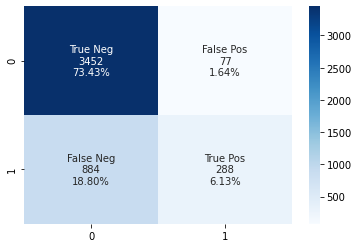

In [53]:
log_model = LogisticRegression(max_iter=1000000)
run_model(log_model,sampled_X_train, X_test, sampled_y_train, y_test)

### K Nearest Neighbours

In [54]:
modelKNN = KNeighborsClassifier()
run_model(modelKNN,sampled_X_train, X_test, sampled_y_train, y_test)

ValueError: The underlying estimator KNeighborsClassifier has no `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to SelectFromModel or call fit before calling transform.

### DecisionTree 

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8233
           1       0.96      0.79      0.86      2734

    accuracy                           0.94     10967
   macro avg       0.94      0.89      0.91     10967
weighted avg       0.94      0.94      0.94     10967

[[8133  100]
 [ 584 2150]]
F1: 0.911203426185031
ROC_AUC: 0.8871236609036146
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------

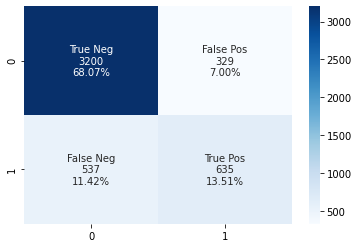

In [33]:
from sklearn.tree import DecisionTreeClassifier
modelTree = DecisionTreeClassifier()
run_model(modelTree,sampled_X_train, X_test, sampled_y_train, y_test)

### Support Vector Classifier

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      8233
           1       0.70      0.53      0.60      2734

    accuracy                           0.82     10967
   macro avg       0.78      0.73      0.74     10967
weighted avg       0.82      0.82      0.82     10967

[[7602  631]
 [1291 1443]]
F1: 0.7440112803935517
ROC_AUC: 0.7255776594824955
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------

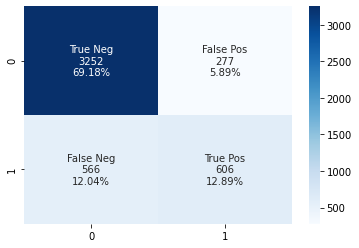

In [34]:
from sklearn.svm import SVC
modelSVC = SVC()
run_model(modelSVC,sampled_X_train, X_test, sampled_y_train, y_test)

### Naive Bayes

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      8233
           1       0.57      0.74      0.65      2734

    accuracy                           0.80     10967
   macro avg       0.74      0.78      0.75     10967
weighted avg       0.82      0.80      0.81     10967

[[6721 1512]
 [ 707 2027]]
F1: 0.7522861047260772
ROC_AUC: 0.7788766877565805
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------

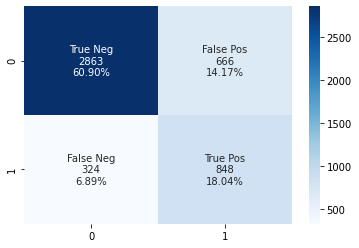

In [35]:
modelNAB = GaussianNB()
run_model(modelNAB,sampled_X_train, X_test, sampled_y_train, y_test)

### Random Forest (Ensemble)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8233
           1       0.92      0.82      0.87      2734

    accuracy                           0.94     10967
   macro avg       0.93      0.90      0.91     10967
weighted avg       0.94      0.94      0.94     10967

[[8029  204]
 [ 481 2253]]
F1: 0.9135641098578757
ROC_AUC: 0.8996444847759266
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------

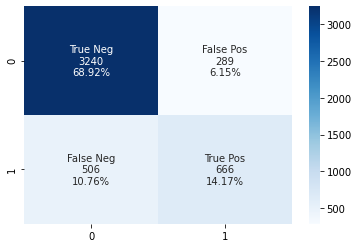

In [36]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier()
run_model(modelRF,sampled_X_train, X_test, sampled_y_train, y_test)

### Gradient Tree Boost (Ensemble)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8233
           1       0.78      0.60      0.68      2734

    accuracy                           0.86     10967
   macro avg       0.83      0.77      0.79     10967
weighted avg       0.85      0.86      0.85     10967

[[7769  464]
 [1090 1644]]
F1: 0.794069255934282
ROC_AUC: 0.772479097492552
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------------------------------------------------

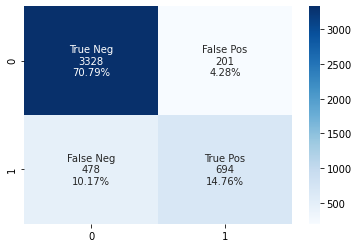

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
modelGBC = GradientBoostingClassifier()
run_model(modelGBC,sampled_X_train, X_test, sampled_y_train, y_test)

### AdaBoost (Ensemble)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8233
           1       0.74      0.59      0.66      2734

    accuracy                           0.85     10967
   macro avg       0.81      0.76      0.78     10967
weighted avg       0.84      0.85      0.84     10967

[[7667  566]
 [1125 1609]]
F1: 0.7781030676072509
ROC_AUC: 0.759883636881247
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------

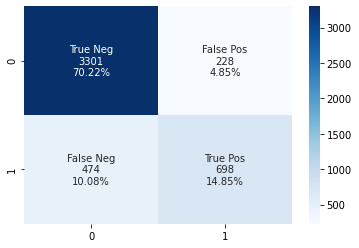

In [38]:
from sklearn.ensemble import AdaBoostClassifier
modelAda = AdaBoostClassifier()
run_model(modelAda,sampled_X_train, X_test, sampled_y_train, y_test)

### Neural Network

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8233
           1       0.75      0.58      0.65      2734

    accuracy                           0.85     10967
   macro avg       0.81      0.76      0.78     10967
weighted avg       0.84      0.85      0.84     10967

[[7696  537]
 [1147 1587]]
F1: 0.7773686734653236
ROC_AUC: 0.7576214328636757
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------

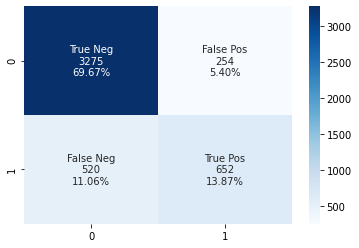

In [39]:
from sklearn.neural_network import MLPClassifier
modelMLP = MLPClassifier()
run_model(modelMLP,sampled_X_train, X_test, sampled_y_train, y_test)

## Feature Selection
In this section, we will eliminate noise from the model.

### Hyperpatameterization

## Produce File for Submission

In [109]:
prepped_data_test = DataPreProcessing(data_test)
prepped_data_test = AlignDataframe(optimizer_X_train.columns,prepped_data_test)

In [110]:
predictions = model.predict(prepped_data_test)
prepped_data_test['Income'] = predictions
prepped_data_test[['Income']].to_csv('Group10_Version19.csv')

In [68]:
# Predict Using H2O
hf2 = h2o.H2OFrame(prepped_data_test)
preds = aml.predict(hf2)
predictions = preds.as_data_frame()
prepped_data_test['Income'] = predictions[['predict']]
final = prepped_data_test.copy()
final.reset_index(inplace=True)
final['Income'] = predictions[['predict']]
final.head()
final[['CITIZEN_ID','Income']].to_csv('Submission_2.csv', index=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
